** Import Required Libraries **

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import psutil
import matplotlib.ticker as ticker

**Creating Synthetic Data**

In [2]:
# ---------------------- Synthetic Data ----------------------
np.random.seed(42)
NUM_NODES = 10
NUM_SOURCES = 3
HOURS = 24

# Random demands per node per hour (10 x 24)
DEMANDS = np.random.randint(10, 50, size=(NUM_NODES, HOURS))

# Source capacities per hour (3 x 24)
CAPACITIES = np.random.randint(80, 150, size=(NUM_SOURCES, HOURS))

# Cost and line loss matrices (3 x 10)
COST = np.random.randint(1, 5, size=(NUM_SOURCES, NUM_NODES))
LOSS = np.random.uniform(0.05, 0.3, size=(NUM_SOURCES, NUM_NODES))

**Genetic Algorithm Parameters**

In [3]:
# ---------------------- GA Parameters ----------------------
POP_SIZE = 50
GENERATIONS = 50
MUTATION_RATE = 0.1

# Chromosome length = sources * nodes * hours
CHROMOSOME_LENGTH = NUM_SOURCES * NUM_NODES * HOURS

In [4]:
# ---------------------- GA Functions ----------------------
def create_chromosome():
    return np.random.randint(0, 10, CHROMOSOME_LENGTH)

def decode_chromosome(chrom):
    return chrom.reshape((NUM_SOURCES, NUM_NODES, HOURS))

def fitness(chrom):
    alloc = decode_chromosome(chrom)
    cost = np.sum(COST[:, :, None] * alloc)
    loss = np.sum(LOSS[:, :, None] * alloc)

    penalty = 0
    for h in range(HOURS):
        for n in range(NUM_NODES):
            total = np.sum(alloc[:, n, h])
            if total != DEMANDS[n, h]:
                penalty += 1000 * abs(total - DEMANDS[n, h])
        for s in range(NUM_SOURCES):
            if np.sum(alloc[s, :, h]) > CAPACITIES[s, h]:
                penalty += 1000 * (np.sum(alloc[s, :, h]) - CAPACITIES[s, h])
    return -(cost + loss + penalty)

def tournament_selection(pop, scores, k=3):
    selection_ix = random.randint(0, len(pop)-1)
    for ix in random.sample(range(len(pop)), k-1):
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

def crossover(p1, p2):
    point = random.randint(1, CHROMOSOME_LENGTH-1)
    return np.concatenate((p1[:point], p2[point:])), np.concatenate((p2[:point], p1[point:]))

def mutate(chrom):
    for i in range(CHROMOSOME_LENGTH):
        if random.random() < MUTATION_RATE:
            chrom[i] = max(0, chrom[i] + random.randint(-5, 5))

In [5]:
# ---------------------- Serial GA ----------------------
def genetic_algorithm_serial():
    pop = [create_chromosome() for _ in range(POP_SIZE)]
    best_scores = []
    for gen in range(GENERATIONS):
        scores = [fitness(c) for c in pop]
        best_scores.append(max(scores))
        selected = [tournament_selection(pop, scores) for _ in range(POP_SIZE)]
        children = []
        for i in range(0, POP_SIZE, 2):
            p1, p2 = selected[i], selected[i+1]
            c1, c2 = crossover(p1, p2)
            mutate(c1)
            mutate(c2)
            children.append(c1)
            children.append(c2)
        pop = children
    return best_scores

In [6]:
# ---------------------- Parallel GA ----------------------
def parallel_fitness(pop):
    with Pool(cpu_count()) as pool:
        scores = pool.map(fitness, pop)
    return scores

def genetic_algorithm_parallel():
    pop = [create_chromosome() for _ in range(POP_SIZE)]
    best_scores = []
    for gen in range(GENERATIONS):
        scores = parallel_fitness(pop)
        best_scores.append(max(scores))
        selected = [tournament_selection(pop, scores) for _ in range(POP_SIZE)]
        children = []
        for i in range(0, POP_SIZE, 2):
            p1, p2 = selected[i], selected[i+1]
            c1, c2 = crossover(p1, p2)
            mutate(c1)
            mutate(c2)
            children.append(c1)
            children.append(c2)
        pop = children
    return best_scores

In [7]:
# ---------------------- Greedy Baseline ----------------------
def greedy_baseline():
    greedy_caps = CAPACITIES.copy()
    total_cost = 0
    penalty = 0
    for h in range(HOURS):
        for n in range(NUM_NODES):
            demand = DEMANDS[n, h]
            sorted_sources = sorted(range(NUM_SOURCES), key=lambda s: COST[s, n])
            for s in sorted_sources:
                alloc = min(demand, greedy_caps[s, h])
                total_cost += alloc * COST[s, n]
                demand -= alloc
                greedy_caps[s, h] -= alloc
                if demand == 0:
                    break
            if demand > 0:
                penalty += 1000 * demand
    return -(total_cost + penalty)

In [8]:
# ---------------------- Main Execution ----------------------
start_serial = time.time()
serial_scores = genetic_algorithm_serial()
serial_time = time.time() - start_serial

start_parallel = time.time()
parallel_scores = genetic_algorithm_parallel()
parallel_time = time.time() - start_parallel

start_greedy = time.time()
greedy_score = greedy_baseline()
end_greedy = time.time()
greedy_time = end_greedy - start_greedy

print(f"Greedy Baseline Time: {greedy_time:.2f} seconds")
print(f"Serial GA time: {serial_time:.2f}s")
print(f"Parallel GA time: {parallel_time:.2f}s")
print(f"Greedy baseline score: {greedy_score:.2f}")

Greedy Baseline Time: 0.00 seconds
Serial GA time: 12.07s
Parallel GA time: 10.35s
Greedy baseline score: -70628.00


In [9]:
# ---------------------- CPU Usage ----------------------
cpu_usage = psutil.cpu_percent(interval=1)
print(f"CPU usage: {cpu_usage}%")

CPU usage: 3.5%


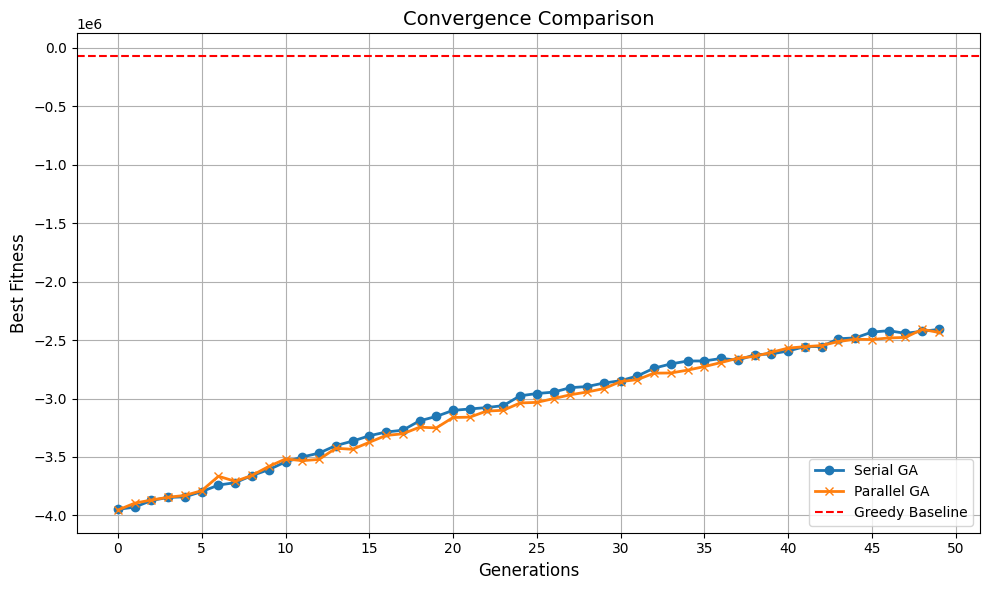

In [10]:
# ---------------------- Plots ----------------------
plt.figure(figsize=(10, 6))
plt.plot(serial_scores, label="Serial GA", marker='o', linewidth=2)
plt.plot(parallel_scores, label="Parallel GA", marker='x', linewidth=2)
plt.axhline(greedy_score, color='r', linestyle='--', label="Greedy Baseline")
plt.title("Convergence Comparison", fontsize=14)
plt.xlabel("Generations", fontsize=12)
plt.ylabel("Best Fitness", fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.tight_layout()
plt.show()

In [11]:
# ---------------------- Trade-off Visualization ----------------------
def run_with_params(pop_size, mutation_rate):
    global POP_SIZE, MUTATION_RATE
    POP_SIZE = pop_size
    MUTATION_RATE = mutation_rate
    start = time.time()
    scores = genetic_algorithm_serial()
    runtime = time.time() - start
    return max(scores), runtime

pop_sizes = [20, 50, 80]
mutation_rates = [0.05, 0.1, 0.2]
results = []

for pop in pop_sizes:
    for mut in mutation_rates:
        best, run = run_with_params(pop, mut)
        results.append((pop, mut, best, run))

print("\nParameter Sensitivity Analysis:")
for r in results:
    print(f"Population: {r[0]}, Mutation: {r[1]:.2f} -> Best Fitness: {r[2]:.2f}, Time: {r[3]:.2f}s")


Parameter Sensitivity Analysis:
Population: 20, Mutation: 0.05 -> Best Fitness: -2759858.98, Time: 2.60s
Population: 20, Mutation: 0.10 -> Best Fitness: -2484837.09, Time: 1.62s
Population: 20, Mutation: 0.20 -> Best Fitness: -2317861.10, Time: 1.69s
Population: 50, Mutation: 0.05 -> Best Fitness: -2738306.19, Time: 3.97s
Population: 50, Mutation: 0.10 -> Best Fitness: -2502222.53, Time: 5.04s
Population: 50, Mutation: 0.20 -> Best Fitness: -2446340.88, Time: 4.52s
Population: 80, Mutation: 0.05 -> Best Fitness: -2498695.55, Time: 7.01s
Population: 80, Mutation: 0.10 -> Best Fitness: -2374399.58, Time: 7.13s
Population: 80, Mutation: 0.20 -> Best Fitness: -2201019.49, Time: 8.07s


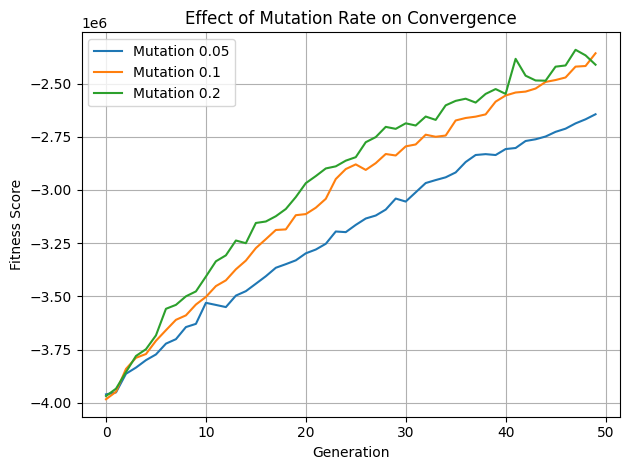

In [12]:
def run_with_params(pop_size, mutation_rate):
    global POP_SIZE, MUTATION_RATE
    POP_SIZE = pop_size
    MUTATION_RATE = mutation_rate
    return genetic_algorithm_serial()

# Example: test different mutation rates
for rate in [0.05, 0.1, 0.2]:
    scores = run_with_params(50, rate)
    plt.plot(scores, label=f"Mutation {rate}")

plt.title("Effect of Mutation Rate on Convergence")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


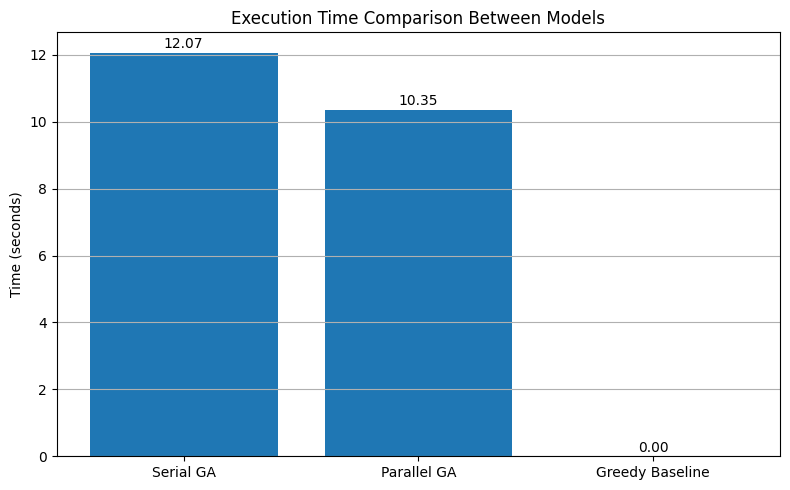

In [13]:
model_names = ['Serial GA', 'Parallel GA', 'Greedy Baseline']
execution_times = [serial_time, parallel_time, greedy_time]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, execution_times)
plt.title('Execution Time Comparison Between Models')
plt.ylabel('Time (seconds)')
plt.grid(axis='y')

# Add values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# Small example
demands = np.array([30, 20, 40])
capacities = np.array([60, 40])
cost = np.array([[2, 3, 1], [4, 2, 5]])
loss = np.array([[0.1, 0.2, 0.05], [0.15, 0.1, 0.1]])

# Energy allocation from source 0 and 1 to node 0, 1, 2
alloc = np.array([
    [[10], [15], [20]],  # source 0
    [[20], [5],  [20]]   # source 1
])  # Shape: (2, 3, 1)

# Cost
cost_total = np.sum(cost[:, :, None] * alloc)
loss_total = np.sum(loss[:, :, None] * alloc)

# Penalties
penalty = 0
for n in range(3):
    total_supply = np.sum(alloc[:, n, 0])
    penalty += abs(demands[n] - total_supply) * 1000

for s in range(2):
    total_out = np.sum(alloc[s, :, 0])
    if total_out > capacities[s]:
        penalty += (total_out - capacities[s]) * 1000

fitness_score = -(cost_total + loss_total + penalty)

print(f"Total Cost: {cost_total:.2f}")
print(f"Total Loss: {loss_total:.2f}")
print(f"Penalty: {penalty}")
print(f"Final Fitness: {fitness_score:.2f}")

Total Cost: 275.00
Total Loss: 10.50
Penalty: 5000
Final Fitness: -5285.50
